In [1]:
import re
import sys
from time import time, sleep
from pprint import pprint
from functools import partial
from multiprocessing import Pool

import numpy as np
import pandas as pd
import optuna
import matplotlib.pyplot as plt

FILENAME = "main.cpp"

In [2]:
!cp ../answer/main.cpp ./{FILENAME}

In [3]:
#!g++ {FILENAME} -std=gnu++17 -Wall -Wextra -O2 -DONLINE_JUDGE -o {FILENAME}.out
!g++ {FILENAME} -std=gnu++17 -Wall -Wextra -O2 -o {FILENAME}.out

main.cpp:49: warning: ignoring #pragma clang attribute [-Wunknown-pragmas]
   49 | #pragma clang attribute push (__attribute__((target("arch=skylake"))),apply_to=function)
      | 
main.cpp:1283: warning: ignoring #pragma clang attribute [-Wunknown-pragmas]
 1283 | #pragma clang attribute pop
      | 
main.cpp: In function ‘void Solve()’:
main.cpp:1192:72: warning: missing initializer for member ‘Solve()::Node::action’ [-Wmissing-field-initializers]
 1192 |   node_buffer.push({ state_buffer[0].score, nullptr, &state_buffer[0] });
      |                                                                        ^
main.cpp: In instantiation of ‘HashMap<T, size, KeyType>::HashMap() [with T = double; int size = 1048576; KeyType = long long unsigned int]’:
main.cpp:535:26:   required from here
main.cpp:477:30: warning: suggest parentheses around ‘-’ in operand of ‘&’ [-Wparentheses]
  477 |   static_assert((size & size - 1) == 0, "not pow of 2");
      |                         ~~~~~^~~
main.c

In [4]:
# テストケース生成
SEED = 1000
N_TESTCASES = 200

!mkdir in
for i in range(N_TESTCASES):
    filename = f"{i:04d}.txt"
    seed = SEED + i
    !python3 ../A/tester/generator.py {seed} > ./in/{filename}
!ls in

0000.txt  0025.txt  0050.txt  0075.txt	0100.txt  0125.txt  0150.txt  0175.txt
0001.txt  0026.txt  0051.txt  0076.txt	0101.txt  0126.txt  0151.txt  0176.txt
0002.txt  0027.txt  0052.txt  0077.txt	0102.txt  0127.txt  0152.txt  0177.txt
0003.txt  0028.txt  0053.txt  0078.txt	0103.txt  0128.txt  0153.txt  0178.txt
0004.txt  0029.txt  0054.txt  0079.txt	0104.txt  0129.txt  0154.txt  0179.txt
0005.txt  0030.txt  0055.txt  0080.txt	0105.txt  0130.txt  0155.txt  0180.txt
0006.txt  0031.txt  0056.txt  0081.txt	0106.txt  0131.txt  0156.txt  0181.txt
0007.txt  0032.txt  0057.txt  0082.txt	0107.txt  0132.txt  0157.txt  0182.txt
0008.txt  0033.txt  0058.txt  0083.txt	0108.txt  0133.txt  0158.txt  0183.txt
0009.txt  0034.txt  0059.txt  0084.txt	0109.txt  0134.txt  0159.txt  0184.txt
0010.txt  0035.txt  0060.txt  0085.txt	0110.txt  0135.txt  0160.txt  0185.txt
0011.txt  0036.txt  0061.txt  0086.txt	0111.txt  0136.txt  0161.txt  0186.txt
0012.txt  0037.txt  0062.txt  0087.txt	0112.txt  0137.txt  0162.

In [5]:
TESTCASE_DIRECTORY = "./in/"
TESTCASES = [f"{i:04d}.txt" for i in range(N_TESTCASES)]

In [7]:
# もとのスコアの確認

scores = []
times = []

!mkdir out

def parallel(i):
    testcase = TESTCASES[i]
    i = f"{i:04d}"
    t0 = time()
    !./{FILENAME}.out < {TESTCASE_DIRECTORY}{testcase} > ./out/{testcase} 2> /dev/null
    t = time() - t0
    score = !python3 ../A/tester/judge.py {TESTCASE_DIRECTORY}{testcase} ./out/{testcase}
    print(i, f"time:{t:.4f}", *score)
    score = int(score[0].split(":")[-1])
    return score, t

with Pool(4) as p:
    for score, t in p.map(parallel, range(N_TESTCASES)):
        scores.append(score)
        times.append(t)

np.mean(scores) * 50 / 1e6, np.std(scores) * 50 / 1e6

mkdir: cannot create directory ‘out’: File exists
0013 time:4.3098 score:4565688
0039 time:4.6223 score:4998935
0026 time:4.9902 score:4697365
0000 time:5.0362 score:4440254
0040 time:3.8789 score:4448945
0014 time:4.2194 score:5083529
0027 time:3.8717 score:5140534
0001 time:5.0256 score:4971467
0041 time:3.8895 score:3780622
0015 time:3.9643 score:5219098
0028 time:4.3334 score:4621682
0002 time:3.6021 score:4217379
0016 time:3.6823 score:4545987
0042 time:4.2501 score:4814997
0029 time:3.5779 score:4624045
0003 time:3.8061 score:4107488
0017 time:4.0112 score:3870332
0043 time:4.0552 score:4567333
0030 time:3.8351 score:4365426
0004 time:3.5112 score:4149345
0018 time:3.6461 score:4672115
0031 time:3.4589 score:3900748
0044 time:3.6654 score:4911358
0005 time:4.3910 score:4812859
0019 time:4.0143 score:4008483
0032 time:3.9397 score:5031385
0045 time:3.8142 score:4524799
0006 time:3.4805 score:4343080
0020 time:4.3364 0033score:4618208
 time:4.0831 score:4056743
0046 time:4.3235 sco

(225.01261425, 16.99567975774754)

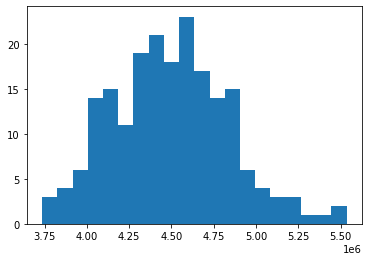

In [8]:
plt.hist(scores, bins=20)
plt.show()

In [9]:
# ここでエラー出力は何かおかしいかもしれない


# パラメータ抽出
with open(FILENAME) as f:
    answer = f.read()


variables_optimize = []

for left, value, right, options in re.findall(r"^([^/\n]*=\s*)(.+?)(\s*;\s*//(?:.*\W)?OPTIMIZE(\W.*))$", answer, re.MULTILINE):
    name = left.replace("=", "").strip().split()[-1]
    
    searched = re.search(r".*\[(?P<min>.*),(?P<max>.*)\].*", options)
    if searched:
        min_value = max_value = None
        try:
            min_value = eval(searched.group("min"))
            max_value = eval(searched.group("max"))
            assert min_value <= max_value
        except Exception as e:
            print(f"searched={searched}", file=sys.stderr)
            print(e, file=sys.stderr)
            continue
        log = "LOG" in options  # 雑、直したほうが良い
        if type(min_value) != type(max_value):
            print(f"searched={searched}", file=sys.stderr)
            print("types not matched", file=sys.stderr)
            continue
        if isinstance(min_value, int):
            method = "suggest_int"
        elif isinstance(min_value, float):
            method = "suggest_float"
        else:
            print(f"searched={searched}", file=sys.stderr)
            print(f"unknown type ({type(min_value)})", file=sys.stderr)
            continue
        variables_optimize.append({
            "name": name,
            "method": method,
            "min": min_value,
            "max": max_value,
            "log": log,
            "left": left,
            "right": right,
        })
    elif searched := re.search(r".*\{(?P<choices>.*?)\}.*", options):
        choices = list(map(lambda x: x.strip(), searched.group("choices").split(",")))
        variables_optimize.append({
            "name": name,
            "method": "suggest_categorical",
            "choices": choices,
            "left": left,
            "right": right,
        })
    else:
        print(f"searched={searched}", file=sys.stderr)
        print(f"pattern was matched but options are incorrect.", file=sys.stderr)

print(len(variables_optimize), "variables were found.")
if globals().get("pd"):
    display(pd.DataFrame(variables_optimize))
else:
    pprint(variables_optimize)

5 variables were found.


,name,method,min,max,log,left,right
0,K_START,suggest_float,0.020,0.060,True,constexpr double K_START =,"; // OPTIMIZE [0.02, 0.06] LOG"
1,K_END,suggest_float,0.010,0.050,True,constexpr double K_END =,"; // OPTIMIZE [0.01, 0.05] LOG"
2,K_H,suggest_float,0.001,0.999,False,constexpr double K_H =,"; // OPTIMIZE [0.001, 0.999]"
3,PURCHASE_TURN_LIMIT,suggest_int,780.000,880.000,False,constexpr short PURCHASE_TURN_LIMIT =,"; // OPTIMIZE [780, 880]"
4,SUBSCORE3_TIGHT_TURN,suggest_int,0.000,2.000,False,constexpr int SUBSCORE3_TIGHT_TURN =,"; // OPTIMIZE [0, 2]"


In [10]:
def escape(string):  # 正規表現の中でそのまま使いたい文字列をエスケープ
    res = !echo '{string}' | sed -e 's/[]\/$*.^[]/\\&/g'
    return res[0]

def escape_sed(string):  # sed の置換後の文字列用のエスケープ
    res = !echo '{string}' | sed -e 's/[\/&]/\\&/g'
    return res[0]


def objective_with_index(trial, n_internal_parallel):
    index_parallel = trial.number % 12  # これ変数にする
    print(f"{index_parallel=}")
    
    parameters_changed_filename = f"{index_parallel}_{FILENAME}"
    #directory_input = "./in"  # "/" をつけない  # 中のすべてのファイルに対して実行される
    
    !mkdir {index_parallel}_out 2> /dev/null
    !mkdir {index_parallel}_score 2> /dev/null
    !rm {index_parallel}_out/*
    !rm {index_parallel}_score/*
    
    # ファイル作成
    !cp {FILENAME} {parameters_changed_filename}
    sed_options = [f"-i {parameters_changed_filename}"]
    for variable in variables_optimize:
        if variable["method"] == "suggest_categorical":
            val =  trial.suggest_categorical(variable["name"], variable["choices"])
        else:
            val = getattr(trial, variable["method"])(variable["name"], variable["min"], variable["max"], log=variable["log"])
        left = variable["left"]
        right = variable["right"]
        sed_options.append(f"""-e 's/^{escape(left)}.*{escape(right)}$/{escape_sed(left)}{val}{escape_sed(right)}/'""")
    command_sed = f"sed {' '.join(sed_options)}"
    print(command_sed)
    !{command_sed}
    
    # コンパイル
    command_compile = f"g++ {parameters_changed_filename} -std=gnu++17 -O2 -DONLINE_JUDGE -o {parameters_changed_filename}.out 2> /dev/null"
    print(command_compile)
    !{command_compile}
    
    # 実行・採点コマンド (@ はファイル名)
    command_exec = (
        f"./{parameters_changed_filename}.out < {TESTCASE_DIRECTORY}@ >./{index_parallel}_out/@ 2> /dev/null;"
        f"python3 ../A/tester/judge.py {TESTCASE_DIRECTORY}@ ./{index_parallel}_out/@ > ./{index_parallel}_score/@"
        
        #f"cargo run --release --manifest-path ../tools/Cargo.toml --bin tester {directory_input}/@ $(pwd)/{parameters_changed_filename}.out 2>&1 | grep Score | sed -E s/[^0-9]+// > ./{index_parallel}_score/@;"
        
        #f"./{parameters_changed_filename}.out < {directory_input}/@ > ./{index_parallel}_out/@;"
        #f"cargo run --release --manifest-path ./tools/Cargo.toml --bin vis {directory_input}/@ ./{index_parallel}_out/@ 2> /dev/null > ./{index_parallel}_score/@;"
    )
    
    # 並列実行 (sed はパスのディレクトリ部分を消してファイル名にしてる)
    !find {TESTCASE_DIRECTORY}/* | sed 's!^.*/!!' | xargs -I@ -P {n_internal_parallel} sh -c '{command_exec}'
    
    # 集計
    file_paths = !find ./{index_parallel}_score/*
    sum_score = 0
    for file_path in file_paths:  
        with open(file_path) as f:
            sum_score += int(f.read().split(":")[-1])
    return sum_score

In [11]:
storage_path = f"study.db"
storage = f"sqlite:///{storage_path}"
study_name = "study"
study = optuna.create_study(storage=storage, load_if_exists=True, study_name=study_name, direction="maximize")

def callback(study, trial):
    try:
        if study.best_value == trial.value:
            print(f"Updated! {study.best_value}")
            index_parallel = trial.number % 12
            parameters_changed_filename = f"{index_parallel}_{FILENAME}"
            !cp {parameters_changed_filename} 00000optimized.cpp
        print("callback ok")
    except:
        print(":(")

objective = partial(objective_with_index, n_internal_parallel=4)
study.optimize(objective, n_trials=3000, timeout=86400, n_jobs=1, callbacks=[callback])

[I 2021-09-09 21:33:06,041] A new study created in RDB with name: study


index_parallel=0
rm: cannot remove '0_out/*': No such file or directory
rm: cannot remove '0_score/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.028029581340962374;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.028869871757885444;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.23428685541701685;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 856;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 1;     \/\/ OPTIMIZE [0, 2]/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-09-09 21:36:36,708] Trial 0 finished with value: 865017861.0 and parameters: {'K_START': 0.028029581340962374, 'K_END': 0.028869871757885444, 'K_H': 0.23428685541701685, 'PURCHASE_TURN_LIMIT': 856, 'SUBSCORE3_TIGHT_TURN': 1}. Best is trial 0 with value: 865017861.0.


Updated! 865017861.0
callback ok
index_parallel=1
rm: cannot remove '1_out/*': No such file or directory
rm: cannot remove '1_score/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.022654026877230737;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.0426225173045377;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9858320519930451;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 875;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 2;     \/\/ OPTIMIZE [0, 2]/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out

[I 2021-09-09 21:40:13,513] Trial 1 finished with value: 866469828.0 and parameters: {'K_START': 0.022654026877230737, 'K_END': 0.0426225173045377, 'K_H': 0.9858320519930451, 'PURCHASE_TURN_LIMIT': 875, 'SUBSCORE3_TIGHT_TURN': 2}. Best is trial 1 with value: 866469828.0.


Updated! 866469828.0
callback ok
index_parallel=2
rm: cannot remove '2_out/*': No such file or directory
rm: cannot remove '2_score/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.0307685121646658;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.03918035951283923;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9138226496059939;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 844;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 

[I 2021-09-09 21:43:48,467] Trial 2 finished with value: 898294439.0 and parameters: {'K_START': 0.0307685121646658, 'K_END': 0.03918035951283923, 'K_H': 0.9138226496059939, 'PURCHASE_TURN_LIMIT': 844, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 2 with value: 898294439.0.


Updated! 898294439.0
callback ok
index_parallel=3
rm: cannot remove '3_out/*': No such file or directory
rm: cannot remove '3_score/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.021310087798977976;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.03171959330474184;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5044934210034417;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 864;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 1;     \/\/ OPTIMIZE [0, 2]/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.ou

[I 2021-09-09 21:47:26,708] Trial 3 finished with value: 858991372.0 and parameters: {'K_START': 0.021310087798977976, 'K_END': 0.03171959330474184, 'K_H': 0.5044934210034417, 'PURCHASE_TURN_LIMIT': 864, 'SUBSCORE3_TIGHT_TURN': 1}. Best is trial 2 with value: 898294439.0.


callback ok
index_parallel=4
rm: cannot remove '4_out/*': No such file or directory
rm: cannot remove '4_score/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.036166504906828545;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.018878625337382375;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.39735791956390376;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 852;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 1;     \/\/ OPTIMIZE [0, 2]/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-09-09 21:51:01,434] Trial 4 finished with value: 846137189.0 and parameters: {'K_START': 0.036166504906828545, 'K_END': 0.018878625337382375, 'K_H': 0.39735791956390376, 'PURCHASE_TURN_LIMIT': 852, 'SUBSCORE3_TIGHT_TURN': 1}. Best is trial 2 with value: 898294439.0.


callback ok
index_parallel=5
rm: cannot remove '5_out/*': No such file or directory
rm: cannot remove '5_score/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.033097566011642945;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.032848038284344565;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5325210001141604;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 780;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-09-09 21:54:21,853] Trial 5 finished with value: 850337880.0 and parameters: {'K_START': 0.033097566011642945, 'K_END': 0.032848038284344565, 'K_H': 0.5325210001141604, 'PURCHASE_TURN_LIMIT': 780, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 2 with value: 898294439.0.


callback ok
index_parallel=6
rm: cannot remove '6_out/*': No such file or directory
rm: cannot remove '6_score/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.0375649055584084;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.02332200680379546;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.02805755682159778;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 868;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 1;     \/\/ OPTIMIZE [0, 2]/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-09-09 21:57:54,746] Trial 6 finished with value: 864199052.0 and parameters: {'K_START': 0.0375649055584084, 'K_END': 0.02332200680379546, 'K_H': 0.02805755682159778, 'PURCHASE_TURN_LIMIT': 868, 'SUBSCORE3_TIGHT_TURN': 1}. Best is trial 2 with value: 898294439.0.


callback ok
index_parallel=7
rm: cannot remove '7_out/*': No such file or directory
rm: cannot remove '7_score/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.02180081669166705;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.016190053045190025;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.742523485510126;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 830;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 2;     \/\/ OPTIMIZE [0, 2]/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-09-09 22:01:14,256] Trial 7 finished with value: 815052907.0 and parameters: {'K_START': 0.02180081669166705, 'K_END': 0.016190053045190025, 'K_H': 0.742523485510126, 'PURCHASE_TURN_LIMIT': 830, 'SUBSCORE3_TIGHT_TURN': 2}. Best is trial 2 with value: 898294439.0.


callback ok
index_parallel=8
rm: cannot remove '8_out/*': No such file or directory
rm: cannot remove '8_score/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.03828392200458128;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.02174492308443573;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.16651144650973304;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 801;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 2;     \/\/ OPTIMIZE [0, 2]/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-09-09 22:04:33,873] Trial 8 finished with value: 853668773.0 and parameters: {'K_START': 0.03828392200458128, 'K_END': 0.02174492308443573, 'K_H': 0.16651144650973304, 'PURCHASE_TURN_LIMIT': 801, 'SUBSCORE3_TIGHT_TURN': 2}. Best is trial 2 with value: 898294439.0.


callback ok
index_parallel=9
rm: cannot remove '9_out/*': No such file or directory
rm: cannot remove '9_score/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05935029627976855;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.03779565954112472;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9113946708337883;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 866;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 2;     \/\/ OPTIMIZE [0, 2]/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-09-09 22:08:15,343] Trial 9 finished with value: 870733838.0 and parameters: {'K_START': 0.05935029627976855, 'K_END': 0.03779565954112472, 'K_H': 0.9113946708337883, 'PURCHASE_TURN_LIMIT': 866, 'SUBSCORE3_TIGHT_TURN': 2}. Best is trial 2 with value: 898294439.0.


callback ok
index_parallel=10
rm: cannot remove '10_out/*': No such file or directory
rm: cannot remove '10_score/*': No such file or directory
sed -i 10_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.048627849514023574;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04840877527928705;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7726823747737877;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 10_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 10_main.cpp.out 2> /dev/null


[I 2021-09-09 22:11:48,914] Trial 10 finished with value: 546717920.0 and parameters: {'K_START': 0.048627849514023574, 'K_END': 0.04840877527928705, 'K_H': 0.7726823747737877, 'PURCHASE_TURN_LIMIT': 834, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 2 with value: 898294439.0.


callback ok
index_parallel=11
rm: cannot remove '11_out/*': No such file or directory
rm: cannot remove '11_score/*': No such file or directory
sed -i 11_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.0582572722443092;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.011055025492672597;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.980383972346936;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 11_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 11_main.cpp.out 2> /dev/null


[I 2021-09-09 22:15:00,721] Trial 11 finished with value: 762533378.0 and parameters: {'K_START': 0.0582572722443092, 'K_END': 0.011055025492672597, 'K_H': 0.980383972346936, 'PURCHASE_TURN_LIMIT': 836, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 2 with value: 898294439.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.028311329430650876;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.038917798436029806;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7671393824664989;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 843;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-09-09 22:18:32,960] Trial 12 finished with value: 892389915.0 and parameters: {'K_START': 0.028311329430650876, 'K_END': 0.038917798436029806, 'K_H': 0.7671393824664989, 'PURCHASE_TURN_LIMIT': 843, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 2 with value: 898294439.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.027863748823343634;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04792364947802781;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7904231954088575;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 817;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-09-09 22:21:58,445] Trial 13 finished with value: 897933066.0 and parameters: {'K_START': 0.027863748823343634, 'K_END': 0.04792364947802781, 'K_H': 0.7904231954088575, 'PURCHASE_TURN_LIMIT': 817, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 2 with value: 898294439.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.027111313333688377;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.047691065279837665;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6574276244974;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 815;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-09-09 22:25:24,292] Trial 14 finished with value: 903171327.0 and parameters: {'K_START': 0.027111313333688377, 'K_END': 0.047691065279837665, 'K_H': 0.6574276244974, 'PURCHASE_TURN_LIMIT': 815, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 14 with value: 903171327.0.


Updated! 903171327.0
callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.02544413308603974;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.028611924180429106;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6196781881088379;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 816;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-09-09 22:28:56,729] Trial 15 finished with value: 868427911.0 and parameters: {'K_START': 0.02544413308603974, 'K_END': 0.028611924180429106, 'K_H': 0.6196781881088379, 'PURCHASE_TURN_LIMIT': 816, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 14 with value: 903171327.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.03203059635247413;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.014133134758358786;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6002567793037568;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 802;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-09-09 22:32:22,932] Trial 16 finished with value: 799701570.0 and parameters: {'K_START': 0.03203059635247413, 'K_END': 0.014133134758358786, 'K_H': 0.6002567793037568, 'PURCHASE_TURN_LIMIT': 802, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 14 with value: 903171327.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.04280780024067509;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.03680094197640816;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8728222544863258;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 818;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 1;     \/\/ OPTIMIZE [0, 2]/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-09-09 22:35:54,460] Trial 17 finished with value: 890739227.0 and parameters: {'K_START': 0.04280780024067509, 'K_END': 0.03680094197640816, 'K_H': 0.8728222544863258, 'PURCHASE_TURN_LIMIT': 818, 'SUBSCORE3_TIGHT_TURN': 1}. Best is trial 14 with value: 903171327.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.024926264859736872;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.026333389410931225;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3785432574211818;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 804;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-09-09 22:39:20,912] Trial 18 finished with value: 852072642.0 and parameters: {'K_START': 0.024926264859736872, 'K_END': 0.026333389410931225, 'K_H': 0.3785432574211818, 'PURCHASE_TURN_LIMIT': 804, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 14 with value: 903171327.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.03107393470335179;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04364253154619483;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6563651272192275;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 845;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 1;     \/\/ OPTIMIZE [0, 2]/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-09-09 22:43:01,369] Trial 19 finished with value: 897776863.0 and parameters: {'K_START': 0.03107393470335179, 'K_END': 0.04364253154619483, 'K_H': 0.6563651272192275, 'PURCHASE_TURN_LIMIT': 845, 'SUBSCORE3_TIGHT_TURN': 1}. Best is trial 14 with value: 903171327.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.0427598273745123;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.049266340916163325;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8809836275392219;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 823;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-09-09 22:46:36,509] Trial 20 finished with value: 591910680.0 and parameters: {'K_START': 0.0427598273745123, 'K_END': 0.049266340916163325, 'K_H': 0.8809836275392219, 'PURCHASE_TURN_LIMIT': 823, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 14 with value: 903171327.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.028067929072947282;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04853652667279796;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6900043615050608;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 808;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-09-09 22:50:11,176] Trial 21 finished with value: 897127552.0 and parameters: {'K_START': 0.028067929072947282, 'K_END': 0.04853652667279796, 'K_H': 0.6900043615050608, 'PURCHASE_TURN_LIMIT': 808, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 14 with value: 903171327.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.024896729886096914;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04268221083222649;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8169704956289343;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 790;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 10_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 10_main.cpp.out 2> /dev/null


[I 2021-09-09 22:53:40,377] Trial 22 finished with value: 875906826.0 and parameters: {'K_START': 0.024896729886096914, 'K_END': 0.04268221083222649, 'K_H': 0.8169704956289343, 'PURCHASE_TURN_LIMIT': 790, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 14 with value: 903171327.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.02962384307034712;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.03444148919254913;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8379078203457369;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 823;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 11_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 11_main.cpp.out 2> /dev/null


[I 2021-09-09 22:57:13,018] Trial 23 finished with value: 890352189.0 and parameters: {'K_START': 0.02962384307034712, 'K_END': 0.03444148919254913, 'K_H': 0.8379078203457369, 'PURCHASE_TURN_LIMIT': 823, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 14 with value: 903171327.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.02605485003021345;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04220799016257337;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7118562808102995;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 813;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-09-09 23:00:41,340] Trial 24 finished with value: 896595206.0 and parameters: {'K_START': 0.02605485003021345, 'K_END': 0.04220799016257337, 'K_H': 0.7118562808102995, 'PURCHASE_TURN_LIMIT': 813, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 14 with value: 903171327.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.02003724270014234;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.03880877880859853;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.565599711289382;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 794;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-09-09 23:04:03,164] Trial 25 finished with value: 874733752.0 and parameters: {'K_START': 0.02003724270014234, 'K_END': 0.03880877880859853, 'K_H': 0.565599711289382, 'PURCHASE_TURN_LIMIT': 794, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 14 with value: 903171327.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.034262412625024864;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.03220578452702475;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.4075988216667052;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 825;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 1;     \/\/ OPTIMIZE [0, 2]/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-09-09 23:07:32,451] Trial 26 finished with value: 881187436.0 and parameters: {'K_START': 0.034262412625024864, 'K_END': 0.03220578452702475, 'K_H': 0.4075988216667052, 'PURCHASE_TURN_LIMIT': 825, 'SUBSCORE3_TIGHT_TURN': 1}. Best is trial 14 with value: 903171327.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.02309826049918839;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04577107628311306;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9306855551140523;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 842;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-09-09 23:11:13,413] Trial 27 finished with value: 897584124.0 and parameters: {'K_START': 0.02309826049918839, 'K_END': 0.04577107628311306, 'K_H': 0.9306855551140523, 'PURCHASE_TURN_LIMIT': 842, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 14 with value: 903171327.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.03100120292164075;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.025604332495745126;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7961778594176399;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 853;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-09-09 23:14:50,235] Trial 28 finished with value: 864148636.0 and parameters: {'K_START': 0.03100120292164075, 'K_END': 0.025604332495745126, 'K_H': 0.7961778594176399, 'PURCHASE_TURN_LIMIT': 853, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 14 with value: 903171327.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.026782212010393797;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.028895739807962662;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.47018322806156704;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 1;     \/\/ OPTIMIZE [0, 2]/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-09-09 23:18:18,010] Trial 29 finished with value: 872053412.0 and parameters: {'K_START': 0.026782212010393797, 'K_END': 0.028895739807962662, 'K_H': 0.47018322806156704, 'PURCHASE_TURN_LIMIT': 836, 'SUBSCORE3_TIGHT_TURN': 1}. Best is trial 14 with value: 903171327.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.02957150275467518;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.040036396466062114;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.27358999202755496;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 810;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 1;     \/\/ OPTIMIZE [0, 2]/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-09-09 23:21:37,018] Trial 30 finished with value: 880961008.0 and parameters: {'K_START': 0.02957150275467518, 'K_END': 0.040036396466062114, 'K_H': 0.27358999202755496, 'PURCHASE_TURN_LIMIT': 810, 'SUBSCORE3_TIGHT_TURN': 1}. Best is trial 14 with value: 903171327.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.030857413875364576;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.049712653310373264;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6426118329809292;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 845;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 1;     \/\/ OPTIMIZE [0, 2]/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-09-09 23:25:02,418] Trial 31 finished with value: 891136146.0 and parameters: {'K_START': 0.030857413875364576, 'K_END': 0.049712653310373264, 'K_H': 0.6426118329809292, 'PURCHASE_TURN_LIMIT': 845, 'SUBSCORE3_TIGHT_TURN': 1}. Best is trial 14 with value: 903171327.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.027527136683407987;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.035413892688072886;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6518747553398766;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 848;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 2;     \/\/ OPTIMIZE [0, 2]/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-09-09 23:28:32,295] Trial 32 finished with value: 882361348.0 and parameters: {'K_START': 0.027527136683407987, 'K_END': 0.035413892688072886, 'K_H': 0.6518747553398766, 'PURCHASE_TURN_LIMIT': 848, 'SUBSCORE3_TIGHT_TURN': 2}. Best is trial 14 with value: 903171327.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.02356279997177545;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.044051951223143065;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6949524086052934;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 862;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 1;     \/\/ OPTIMIZE [0, 2]/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-09-09 23:32:14,329] Trial 33 finished with value: 885930250.0 and parameters: {'K_START': 0.02356279997177545, 'K_END': 0.044051951223143065, 'K_H': 0.6949524086052934, 'PURCHASE_TURN_LIMIT': 862, 'SUBSCORE3_TIGHT_TURN': 1}. Best is trial 14 with value: 903171327.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.03524391096959885;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.044330694536915065;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9679229202742547;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 860;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 10_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 10_main.cpp.out 2> /dev/null


[I 2021-09-09 23:35:51,171] Trial 34 finished with value: 855063299.0 and parameters: {'K_START': 0.03524391096959885, 'K_END': 0.044330694536915065, 'K_H': 0.9679229202742547, 'PURCHASE_TURN_LIMIT': 860, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 14 with value: 903171327.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.03331533498548736;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04144759680393727;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8483483856818045;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 876;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 1;     \/\/ OPTIMIZE [0, 2]/'
g++ 11_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 11_main.cpp.out 2> /dev/null


[I 2021-09-09 23:39:27,141] Trial 35 finished with value: 862240266.0 and parameters: {'K_START': 0.03331533498548736, 'K_END': 0.04144759680393727, 'K_H': 0.8483483856818045, 'PURCHASE_TURN_LIMIT': 876, 'SUBSCORE3_TIGHT_TURN': 1}. Best is trial 14 with value: 903171327.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.02954305670298909;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.031764717972038205;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.4921765818472452;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 828;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-09-09 23:42:46,104] Trial 36 finished with value: 885005071.0 and parameters: {'K_START': 0.02954305670298909, 'K_END': 0.031764717972038205, 'K_H': 0.4921765818472452, 'PURCHASE_TURN_LIMIT': 828, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 14 with value: 903171327.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.039359942661812336;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.045886396455751946;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.579863719486451;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 819;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 1;     \/\/ OPTIMIZE [0, 2]/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-09-09 23:46:06,576] Trial 37 finished with value: 871607046.0 and parameters: {'K_START': 0.039359942661812336, 'K_END': 0.045886396455751946, 'K_H': 0.579863719486451, 'PURCHASE_TURN_LIMIT': 819, 'SUBSCORE3_TIGHT_TURN': 1}. Best is trial 14 with value: 903171327.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.023817620194531715;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.017863199997112954;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7192338206283447;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 856;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 2;     \/\/ OPTIMIZE [0, 2]/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-09-09 23:49:19,669] Trial 38 finished with value: 821967782.0 and parameters: {'K_START': 0.023817620194531715, 'K_END': 0.017863199997112954, 'K_H': 0.7192338206283447, 'PURCHASE_TURN_LIMIT': 856, 'SUBSCORE3_TIGHT_TURN': 2}. Best is trial 14 with value: 903171327.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.032002202955631553;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.010013352685334648;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9316935321027994;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-09-09 23:52:15,525] Trial 39 finished with value: 748007441.0 and parameters: {'K_START': 0.032002202955631553, 'K_END': 0.010013352685334648, 'K_H': 0.9316935321027994, 'PURCHASE_TURN_LIMIT': 838, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 14 with value: 903171327.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.026626478479211797;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.03462130112448529;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.531779065565328;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 829;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 1;     \/\/ OPTIMIZE [0, 2]/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-09-09 23:55:27,269] Trial 40 finished with value: 884166630.0 and parameters: {'K_START': 0.026626478479211797, 'K_END': 0.03462130112448529, 'K_H': 0.531779065565328, 'PURCHASE_TURN_LIMIT': 829, 'SUBSCORE3_TIGHT_TURN': 1}. Best is trial 14 with value: 903171327.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.022465523370286917;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04481776656982974;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9088211749837308;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 843;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-09-09 23:58:47,044] Trial 41 finished with value: 905334589.0 and parameters: {'K_START': 0.022465523370286917, 'K_END': 0.04481776656982974, 'K_H': 0.9088211749837308, 'PURCHASE_TURN_LIMIT': 843, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 41 with value: 905334589.0.


Updated! 905334589.0
callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.021182095583160292;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.045113665683593186;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8033070174652263;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 849;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-09-10 00:02:04,661] Trial 42 finished with value: 900321977.0 and parameters: {'K_START': 0.021182095583160292, 'K_END': 0.045113665683593186, 'K_H': 0.8033070174652263, 'PURCHASE_TURN_LIMIT': 849, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 41 with value: 905334589.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.02169375208517658;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04011768697978872;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8995539857301339;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 851;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-09-10 00:05:28,592] Trial 43 finished with value: 891454316.0 and parameters: {'K_START': 0.02169375208517658, 'K_END': 0.04011768697978872, 'K_H': 0.8995539857301339, 'PURCHASE_TURN_LIMIT': 851, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 41 with value: 905334589.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.020804274090843324;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04559481792979807;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7688639953694293;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-09-10 00:08:48,320] Trial 44 finished with value: 898635022.0 and parameters: {'K_START': 0.020804274090843324, 'K_END': 0.04559481792979807, 'K_H': 0.7688639953694293, 'PURCHASE_TURN_LIMIT': 840, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 41 with value: 905334589.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.020004895663346265;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.03767550426971361;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9935948381496099;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-09-10 00:12:10,461] Trial 45 finished with value: 895777683.0 and parameters: {'K_START': 0.020004895663346265, 'K_END': 0.03767550426971361, 'K_H': 0.9935948381496099, 'PURCHASE_TURN_LIMIT': 840, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 41 with value: 905334589.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.022169064820762207;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.046006240750748675;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7542004257825138;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 870;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 10_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 10_main.cpp.out 2> /dev/null


[I 2021-09-10 00:15:44,596] Trial 46 finished with value: 879360865.0 and parameters: {'K_START': 0.022169064820762207, 'K_END': 0.046006240750748675, 'K_H': 0.7542004257825138, 'PURCHASE_TURN_LIMIT': 870, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 41 with value: 905334589.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.02131608060821953;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.02220536030091828;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8494143515610614;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 11_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 11_main.cpp.out 2> /dev/null


[I 2021-09-10 00:19:09,518] Trial 47 finished with value: 850419752.0 and parameters: {'K_START': 0.02131608060821953, 'K_END': 0.02220536030091828, 'K_H': 0.8494143515610614, 'PURCHASE_TURN_LIMIT': 832, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 41 with value: 905334589.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.020684329795192212;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.013575988213093665;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.936907414054418;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 849;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-09-10 00:22:31,466] Trial 48 finished with value: 791595467.0 and parameters: {'K_START': 0.020684329795192212, 'K_END': 0.013575988213093665, 'K_H': 0.936907414054418, 'PURCHASE_TURN_LIMIT': 849, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 41 with value: 905334589.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.02271816895595896;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.0364088257259799;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7970847608644804;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 857;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-09-10 00:26:10,606] Trial 49 finished with value: 881211255.0 and parameters: {'K_START': 0.02271816895595896, 'K_END': 0.0364088257259799, 'K_H': 0.7970847608644804, 'PURCHASE_TURN_LIMIT': 857, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 41 with value: 905334589.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.021109935841426314;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.029820407755841584;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.05735681019172534;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-09-10 00:29:48,082] Trial 50 finished with value: 862856103.0 and parameters: {'K_START': 0.021109935841426314, 'K_END': 0.029820407755841584, 'K_H': 0.05735681019172534, 'PURCHASE_TURN_LIMIT': 835, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 41 with value: 905334589.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.02415638348248438;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04674424231460884;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7773055758550959;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 847;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-09-10 00:33:41,727] Trial 51 finished with value: 903217740.0 and parameters: {'K_START': 0.02415638348248438, 'K_END': 0.04674424231460884, 'K_H': 0.7773055758550959, 'PURCHASE_TURN_LIMIT': 847, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 41 with value: 905334589.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.024362147085742233;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.046498027591047576;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7464137079248795;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 845;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-09-10 00:37:39,048] Trial 52 finished with value: 901522120.0 and parameters: {'K_START': 0.024362147085742233, 'K_END': 0.046498027591047576, 'K_H': 0.7464137079248795, 'PURCHASE_TURN_LIMIT': 845, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 41 with value: 905334589.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.024376101888378292;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04580352766378642;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7505069838826806;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 847;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-09-10 00:41:28,156] Trial 53 finished with value: 902037188.0 and parameters: {'K_START': 0.024376101888378292, 'K_END': 0.04580352766378642, 'K_H': 0.7505069838826806, 'PURCHASE_TURN_LIMIT': 847, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 41 with value: 905334589.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.02418747072397331;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04086201370274158;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7310559921489227;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 847;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-09-10 00:45:22,278] Trial 54 finished with value: 897459273.0 and parameters: {'K_START': 0.02418747072397331, 'K_END': 0.04086201370274158, 'K_H': 0.7310559921489227, 'PURCHASE_TURN_LIMIT': 847, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 41 with value: 905334589.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.02474637153360974;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.049433902859831846;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8349185831564251;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 851;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-09-10 00:49:19,630] Trial 55 finished with value: 867524409.0 and parameters: {'K_START': 0.02474637153360974, 'K_END': 0.049433902859831846, 'K_H': 0.8349185831564251, 'PURCHASE_TURN_LIMIT': 851, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 41 with value: 905334589.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.022517327147931886;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04687562987650856;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8697874539882926;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 854;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-09-10 00:53:12,059] Trial 56 finished with value: 898380768.0 and parameters: {'K_START': 0.022517327147931886, 'K_END': 0.04687562987650856, 'K_H': 0.8697874539882926, 'PURCHASE_TURN_LIMIT': 854, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 41 with value: 905334589.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.025444918461969043;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.042014121227110776;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6715778536405516;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 871;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-09-10 00:57:18,862] Trial 57 finished with value: 869020546.0 and parameters: {'K_START': 0.025444918461969043, 'K_END': 0.042014121227110776, 'K_H': 0.6715778536405516, 'PURCHASE_TURN_LIMIT': 871, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 41 with value: 905334589.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.023479326099140864;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.0384551978312118;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6149128735477034;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 859;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 10_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 10_main.cpp.out 2> /dev/null


[I 2021-09-10 01:01:05,302] Trial 58 finished with value: 880083698.0 and parameters: {'K_START': 0.023479326099140864, 'K_END': 0.0384551978312118, 'K_H': 0.6149128735477034, 'PURCHASE_TURN_LIMIT': 859, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 41 with value: 905334589.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.025792360307571014;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04391090914305764;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7463965688852889;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 866;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 11_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 11_main.cpp.out 2> /dev/null


[I 2021-09-10 01:04:59,708] Trial 59 finished with value: 882352824.0 and parameters: {'K_START': 0.025792360307571014, 'K_END': 0.04391090914305764, 'K_H': 0.7463965688852889, 'PURCHASE_TURN_LIMIT': 866, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 41 with value: 905334589.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05506873033140802;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.033315555301365964;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8155771866000154;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 844;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-09-10 01:08:52,226] Trial 60 finished with value: 896378782.0 and parameters: {'K_START': 0.05506873033140802, 'K_END': 0.033315555301365964, 'K_H': 0.8155771866000154, 'PURCHASE_TURN_LIMIT': 844, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 41 with value: 905334589.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.022244877076497534;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.047193067133304525;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.776779949127949;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 841;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-09-10 01:12:46,064] Trial 61 finished with value: 907198219.0 and parameters: {'K_START': 0.022244877076497534, 'K_END': 0.047193067133304525, 'K_H': 0.776779949127949, 'PURCHASE_TURN_LIMIT': 841, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 61 with value: 907198219.0.


Updated! 907198219.0
callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.022296580372028935;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04725466327607322;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7775153727944405;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 841;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-09-10 01:16:56,391] Trial 62 finished with value: 904724684.0 and parameters: {'K_START': 0.022296580372028935, 'K_END': 0.04725466327607322, 'K_H': 0.7775153727944405, 'PURCHASE_TURN_LIMIT': 841, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 61 with value: 907198219.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.024216058366701;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04750282563626842;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7109973735579753;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-09-10 01:20:49,850] Trial 63 finished with value: 907422216.0 and parameters: {'K_START': 0.024216058366701, 'K_END': 0.04750282563626842, 'K_H': 0.7109973735579753, 'PURCHASE_TURN_LIMIT': 832, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 63 with value: 907422216.0.


Updated! 907422216.0
callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.022233627695374396;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04953663190751662;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.686730643126839;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-09-10 01:24:53,884] Trial 64 finished with value: 905723207.0 and parameters: {'K_START': 0.022233627695374396, 'K_END': 0.04953663190751662, 'K_H': 0.686730643126839, 'PURCHASE_TURN_LIMIT': 832, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 63 with value: 907422216.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.022502825812231377;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04865615379113029;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6854776932686412;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-09-10 01:28:30,502] Trial 65 finished with value: 907879774.0 and parameters: {'K_START': 0.022502825812231377, 'K_END': 0.04865615379113029, 'K_H': 0.6854776932686412, 'PURCHASE_TURN_LIMIT': 833, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 65 with value: 907879774.0.


Updated! 907879774.0
callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.022102594815270694;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04931565810913515;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.627642815223125;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 827;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-09-10 01:31:50,560] Trial 66 finished with value: 902142370.0 and parameters: {'K_START': 0.022102594815270694, 'K_END': 0.04931565810913515, 'K_H': 0.627642815223125, 'PURCHASE_TURN_LIMIT': 827, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 65 with value: 907879774.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.022919307438604156;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.02045960913591957;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7019157490199356;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-09-10 01:35:30,252] Trial 67 finished with value: 844286982.0 and parameters: {'K_START': 0.022919307438604156, 'K_END': 0.02045960913591957, 'K_H': 0.7019157490199356, 'PURCHASE_TURN_LIMIT': 832, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 65 with value: 907879774.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.021942604605686332;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04230694000255793;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8941144669178578;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-09-10 01:39:02,632] Trial 68 finished with value: 903100413.0 and parameters: {'K_START': 0.021942604605686332, 'K_END': 0.04230694000255793, 'K_H': 0.8941144669178578, 'PURCHASE_TURN_LIMIT': 837, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 65 with value: 907879774.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.020490394077043488;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04969533538693076;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5842041617249434;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-09-10 01:42:25,675] Trial 69 finished with value: 901092561.0 and parameters: {'K_START': 0.020490394077043488, 'K_END': 0.04969533538693076, 'K_H': 0.5842041617249434, 'PURCHASE_TURN_LIMIT': 832, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 65 with value: 907879774.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.023197248371944496;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.039766637151191546;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6775064724365345;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 841;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 10_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 10_main.cpp.out 2> /dev/null


[I 2021-09-10 01:45:56,752] Trial 70 finished with value: 893546156.0 and parameters: {'K_START': 0.023197248371944496, 'K_END': 0.039766637151191546, 'K_H': 0.6775064724365345, 'PURCHASE_TURN_LIMIT': 841, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 65 with value: 907879774.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.02228374739475911;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04754833610728247;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7830396513759729;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 820;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 11_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 11_main.cpp.out 2> /dev/null


[I 2021-09-10 01:49:20,669] Trial 71 finished with value: 908281467.0 and parameters: {'K_START': 0.02228374739475911, 'K_END': 0.04754833610728247, 'K_H': 0.7830396513759729, 'PURCHASE_TURN_LIMIT': 820, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 71 with value: 908281467.0.


Updated! 908281467.0
callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.021635694713127943;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04735868921458267;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7150793182507715;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 820;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-09-10 01:53:00,401] Trial 72 finished with value: 898092948.0 and parameters: {'K_START': 0.021635694713127943, 'K_END': 0.04735868921458267, 'K_H': 0.7150793182507715, 'PURCHASE_TURN_LIMIT': 820, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 71 with value: 908281467.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.022618794327078206;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.043236399941184285;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7776371677280262;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 823;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-09-10 01:56:45,008] Trial 73 finished with value: 901705899.0 and parameters: {'K_START': 0.022618794327078206, 'K_END': 0.043236399941184285, 'K_H': 0.7776371677280262, 'PURCHASE_TURN_LIMIT': 823, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 71 with value: 908281467.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.023613341847949644;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.047947289274026195;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8254579358482287;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-09-10 02:00:27,878] Trial 74 finished with value: 904703496.0 and parameters: {'K_START': 0.023613341847949644, 'K_END': 0.047947289274026195, 'K_H': 0.8254579358482287, 'PURCHASE_TURN_LIMIT': 834, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 71 with value: 908281467.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.023515579791454303;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04768588020027384;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8620257917642015;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 826;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-09-10 02:04:06,200] Trial 75 finished with value: 898248700.0 and parameters: {'K_START': 0.023515579791454303, 'K_END': 0.04768588020027384, 'K_H': 0.8620257917642015, 'PURCHASE_TURN_LIMIT': 826, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 71 with value: 908281467.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.026037221519476808;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04358926698222627;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8022559107137123;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 831;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-09-10 02:07:44,929] Trial 76 finished with value: 902148089.0 and parameters: {'K_START': 0.026037221519476808, 'K_END': 0.04358926698222627, 'K_H': 0.8022559107137123, 'PURCHASE_TURN_LIMIT': 831, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 71 with value: 908281467.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.02504403887213596;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.0412935950218053;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9439525808198147;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-09-10 02:11:09,037] Trial 77 finished with value: 902406281.0 and parameters: {'K_START': 0.02504403887213596, 'K_END': 0.0412935950218053, 'K_H': 0.9439525808198147, 'PURCHASE_TURN_LIMIT': 839, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 71 with value: 908281467.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.020492815890190398;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04807944831042553;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8349077490402306;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-09-10 02:14:32,245] Trial 78 finished with value: 907588760.0 and parameters: {'K_START': 0.020492815890190398, 'K_END': 0.04807944831042553, 'K_H': 0.8349077490402306, 'PURCHASE_TURN_LIMIT': 834, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 71 with value: 908281467.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.020571213392634354;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.049905602412097363;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8851492795637;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 814;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-09-10 02:17:51,798] Trial 79 finished with value: 847575443.0 and parameters: {'K_START': 0.020571213392634354, 'K_END': 0.049905602412097363, 'K_H': 0.8851492795637, 'PURCHASE_TURN_LIMIT': 814, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 71 with value: 908281467.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.021425665229207306;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04470404803836288;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.549998872584083;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 821;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-09-10 02:21:17,794] Trial 80 finished with value: 900192070.0 and parameters: {'K_START': 0.021425665229207306, 'K_END': 0.04470404803836288, 'K_H': 0.549998872584083, 'PURCHASE_TURN_LIMIT': 821, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 71 with value: 908281467.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.02242231335983674;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04769075955173356;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.836330644417324;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-09-10 02:24:56,741] Trial 81 finished with value: 907201769.0 and parameters: {'K_START': 0.02242231335983674, 'K_END': 0.04769075955173356, 'K_H': 0.836330644417324, 'PURCHASE_TURN_LIMIT': 834, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 71 with value: 908281467.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.022220404924123954;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.042823333972009846;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8361868202679844;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 10_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 10_main.cpp.out 2> /dev/null


[I 2021-09-10 02:28:31,056] Trial 82 finished with value: 901810140.0 and parameters: {'K_START': 0.022220404924123954, 'K_END': 0.042823333972009846, 'K_H': 0.8361868202679844, 'PURCHASE_TURN_LIMIT': 836, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 71 with value: 908281467.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.020033489656798967;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.024328715584645628;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9166152847248511;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 830;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 11_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 11_main.cpp.out 2> /dev/null


[I 2021-09-10 02:31:57,654] Trial 83 finished with value: 862005695.0 and parameters: {'K_START': 0.020033489656798967, 'K_END': 0.024328715584645628, 'K_H': 0.9166152847248511, 'PURCHASE_TURN_LIMIT': 830, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 71 with value: 908281467.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.022843510679125465;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04771026954261854;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7234497560861808;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 842;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-09-10 02:35:28,388] Trial 84 finished with value: 904788381.0 and parameters: {'K_START': 0.022843510679125465, 'K_END': 0.04771026954261854, 'K_H': 0.7234497560861808, 'PURCHASE_TURN_LIMIT': 842, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 71 with value: 908281467.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.02293890512361201;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.0446762442337008;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6903598335806105;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-09-10 02:39:00,784] Trial 85 finished with value: 901804850.0 and parameters: {'K_START': 0.02293890512361201, 'K_END': 0.0446762442337008, 'K_H': 0.6903598335806105, 'PURCHASE_TURN_LIMIT': 834, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 71 with value: 908281467.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.02102191609995416;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04991671916312796;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9697054082485852;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-09-10 02:42:39,490] Trial 86 finished with value: 680848493.0 and parameters: {'K_START': 0.02102191609995416, 'K_END': 0.04991671916312796, 'K_H': 0.9697054082485852, 'PURCHASE_TURN_LIMIT': 838, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 71 with value: 908281467.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.02166115444159505;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04058337099753424;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7238025966335576;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 826;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-09-10 02:46:10,959] Trial 87 finished with value: 894906285.0 and parameters: {'K_START': 0.02166115444159505, 'K_END': 0.04058337099753424, 'K_H': 0.7238025966335576, 'PURCHASE_TURN_LIMIT': 826, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 71 with value: 908281467.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.020592338240400878;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.0379764122902192;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8643148259708843;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 843;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 2;     \/\/ OPTIMIZE [0, 2]/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-09-10 02:49:48,578] Trial 88 finished with value: 885803942.0 and parameters: {'K_START': 0.020592338240400878, 'K_END': 0.0379764122902192, 'K_H': 0.8643148259708843, 'PURCHASE_TURN_LIMIT': 843, 'SUBSCORE3_TIGHT_TURN': 2}. Best is trial 71 with value: 908281467.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.022755546143712686;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04808787736886043;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6535794718912104;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 824;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-09-10 02:53:23,941] Trial 89 finished with value: 905479737.0 and parameters: {'K_START': 0.022755546143712686, 'K_END': 0.04808787736886043, 'K_H': 0.6535794718912104, 'PURCHASE_TURN_LIMIT': 824, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 71 with value: 908281467.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.021735797097203698;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.014652684919451547;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6599992573627322;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 824;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-09-10 02:56:57,587] Trial 90 finished with value: 805108943.0 and parameters: {'K_START': 0.021735797097203698, 'K_END': 0.014652684919451547, 'K_H': 0.6599992573627322, 'PURCHASE_TURN_LIMIT': 824, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 71 with value: 908281467.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.023149826703441297;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.048075013891900865;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6381528849685336;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 829;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-09-10 03:00:29,427] Trial 91 finished with value: 907673947.0 and parameters: {'K_START': 0.023149826703441297, 'K_END': 0.048075013891900865, 'K_H': 0.6381528849685336, 'PURCHASE_TURN_LIMIT': 829, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 71 with value: 908281467.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.023986669701902778;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04561197056024142;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6208210617538668;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 829;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-09-10 03:04:10,646] Trial 92 finished with value: 902229063.0 and parameters: {'K_START': 0.023986669701902778, 'K_END': 0.04561197056024142, 'K_H': 0.6208210617538668, 'PURCHASE_TURN_LIMIT': 829, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 71 with value: 908281467.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.02310742866216719;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04829497413730967;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6481666654434454;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 880;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-09-10 03:07:54,541] Trial 93 finished with value: 859188056.0 and parameters: {'K_START': 0.02310742866216719, 'K_END': 0.04829497413730967, 'K_H': 0.6481666654434454, 'PURCHASE_TURN_LIMIT': 880, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 71 with value: 908281467.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.02102556360111433;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04426226353324363;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6781714760736075;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 811;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 10_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 10_main.cpp.out 2> /dev/null


[I 2021-09-10 03:11:17,929] Trial 94 finished with value: 894852079.0 and parameters: {'K_START': 0.02102556360111433, 'K_END': 0.04426226353324363, 'K_H': 0.6781714760736075, 'PURCHASE_TURN_LIMIT': 811, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 71 with value: 908281467.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.02469038483396723;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04193730225855753;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.759296498751286;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 818;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 11_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 11_main.cpp.out 2> /dev/null


[I 2021-09-10 03:14:54,502] Trial 95 finished with value: 897225529.0 and parameters: {'K_START': 0.02469038483396723, 'K_END': 0.04193730225855753, 'K_H': 0.759296498751286, 'PURCHASE_TURN_LIMIT': 818, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 71 with value: 908281467.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.02238995345705376;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04615017260313044;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6319290859288067;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 822;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-09-10 03:18:22,050] Trial 96 finished with value: 899884688.0 and parameters: {'K_START': 0.02238995345705376, 'K_END': 0.04615017260313044, 'K_H': 0.6319290859288067, 'PURCHASE_TURN_LIMIT': 822, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 71 with value: 908281467.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.020391196745071095;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04844228632845984;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.595883325853743;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 828;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-09-10 03:21:50,232] Trial 97 finished with value: 905691877.0 and parameters: {'K_START': 0.020391196745071095, 'K_END': 0.04844228632845984, 'K_H': 0.595883325853743, 'PURCHASE_TURN_LIMIT': 828, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 71 with value: 908281467.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.0204387820904594;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04788707123930524;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.4611712744787681;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-09-10 03:25:20,661] Trial 98 finished with value: 901423673.0 and parameters: {'K_START': 0.0204387820904594, 'K_END': 0.04788707123930524, 'K_H': 0.4611712744787681, 'PURCHASE_TURN_LIMIT': 833, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 71 with value: 908281467.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.02142346077505086;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.03659939126357597;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5829701816652807;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 816;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-09-10 03:28:57,520] Trial 99 finished with value: 883081068.0 and parameters: {'K_START': 0.02142346077505086, 'K_END': 0.03659939126357597, 'K_H': 0.5829701816652807, 'PURCHASE_TURN_LIMIT': 816, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 71 with value: 908281467.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.02191746301634125;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.03928708502905512;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5653206144013834;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 828;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-09-10 03:32:32,928] Trial 100 finished with value: 895212558.0 and parameters: {'K_START': 0.02191746301634125, 'K_END': 0.03928708502905512, 'K_H': 0.5653206144013834, 'PURCHASE_TURN_LIMIT': 828, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 71 with value: 908281467.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.04339342633394555;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04446193145681512;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5195743483645378;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 825;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-09-10 03:36:00,723] Trial 101 finished with value: 835575680.0 and parameters: {'K_START': 0.04339342633394555, 'K_END': 0.04446193145681512, 'K_H': 0.5195743483645378, 'PURCHASE_TURN_LIMIT': 825, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 71 with value: 908281467.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.021003835186361796;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.0484447736977684;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6020906623406183;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 830;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-09-10 03:39:30,688] Trial 102 finished with value: 905511881.0 and parameters: {'K_START': 0.021003835186361796, 'K_END': 0.0484447736977684, 'K_H': 0.6020906623406183, 'PURCHASE_TURN_LIMIT': 830, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 71 with value: 908281467.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.020298301153123127;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04990635952636971;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7022139010048758;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 830;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-09-10 03:43:02,419] Trial 103 finished with value: 905333207.0 and parameters: {'K_START': 0.020298301153123127, 'K_END': 0.04990635952636971, 'K_H': 0.7022139010048758, 'PURCHASE_TURN_LIMIT': 830, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 71 with value: 908281467.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.02107233560622565;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04837330345359281;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6068194837376637;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-09-10 03:46:49,749] Trial 104 finished with value: 903435035.0 and parameters: {'K_START': 0.02107233560622565, 'K_END': 0.04837330345359281, 'K_H': 0.6068194837376637, 'PURCHASE_TURN_LIMIT': 836, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 71 with value: 908281467.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.023684651315285833;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04652107876916136;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6676996005319429;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 828;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-09-10 03:50:24,518] Trial 105 finished with value: 905737837.0 and parameters: {'K_START': 0.023684651315285833, 'K_END': 0.04652107876916136, 'K_H': 0.6676996005319429, 'PURCHASE_TURN_LIMIT': 828, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 71 with value: 908281467.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.02374431554918074;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.042972155804894836;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5954143483764675;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 827;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/'
g++ 10_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 10_main.cpp.out 2> /dev/null
^C


[I 2021-09-10 03:50:33,701] Trial 106 finished with value: 17916787.0 and parameters: {'K_START': 0.02374431554918074, 'K_END': 0.042972155804894836, 'K_H': 0.5954143483764675, 'PURCHASE_TURN_LIMIT': 827, 'SUBSCORE3_TIGHT_TURN': 0}. Best is trial 71 with value: 908281467.0.


callback ok
index_parallel=11


KeyboardInterrupt: 